# Vehicle Price Prediction in Machine Learning

# Installation

In [1]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


# Import all required libraries

In [1]:
import pickle
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split , StratifiedShuffleSplit , RandomizedSearchCV
warnings.filterwarnings('ignore')

# Perform EDA

In [2]:
df = pd.read_csv('Dataset/cars_data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
print(df.shape)
print(df['Fuel_Type'].unique())
print(df['Seller_Type'].unique())
print(df['Transmission'].unique())
print(df['Owner'].unique())

(301, 9)
['Petrol' 'Diesel' 'CNG']
['Dealer' 'Individual']
['Manual' 'Automatic']
[0 1 3]


In [4]:
# Check that there is null values or not

df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [5]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
df1 = df.drop(columns='Car_Name')
df1.shape

(301, 8)

In [7]:
# add column of how old vehicle 
# Find today's date for check that how much car is old

x = datetime.datetime.now()
x.year

df1['how_old'] = x.year - df1.Year
df1.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,how_old
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,9
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,10
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,6
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,12
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,9


In [8]:
# data manipulation - categorical features into the numeric features; applied OneHotEncoding

df1.drop(columns = 'Year' , axis=1 , inplace=True)

df1 = pd.get_dummies(df1 , drop_first=True)
df1.head()      

,Selling_Price,Present_Price,Kms_Driven,Owner,how_old,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,9,False,True,False,True
1,4.75,9.54,43000,0,10,True,False,False,True
2,7.25,9.85,6900,0,6,False,True,False,True
3,2.85,4.15,5200,0,12,False,True,False,True
4,4.60,6.87,42450,0,9,True,False,False,True


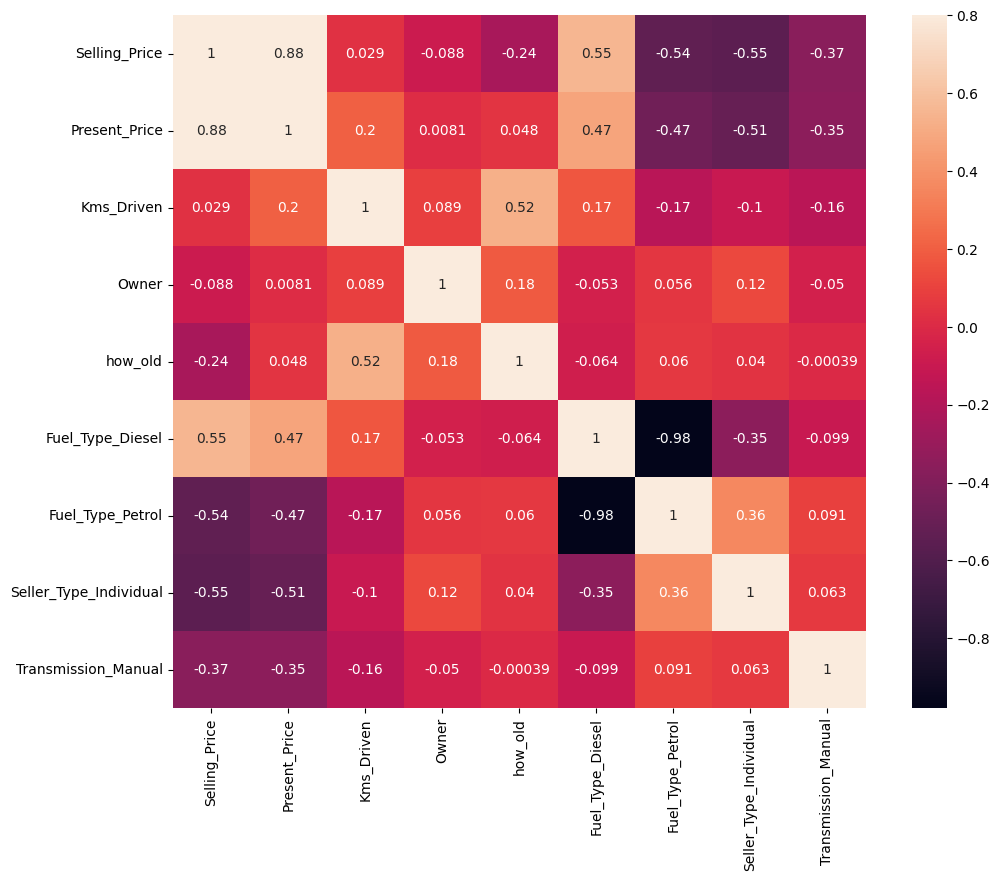

In [9]:
# Visualize the correlation using correlation matrix

corrmat = df1.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, annot_kws={'size': 10}, annot = True, square=True);

# top_corr_features = corrmat.index
# plt.figure(figsize = (25, 25))
# sns.heatmap(df1[top_corr_features].corr() , annot=True , cmap='Accent')

In [10]:
# divide data into dependent and independent features

X = df1.drop(columns='Selling_Price')
y = df1['Selling_Price']

# Split data into training and testing

shuffle = StratifiedShuffleSplit(random_state=51 , test_size=0.2 , n_splits=1)

for train_index , test_index in shuffle.split(df1 , df1['Fuel_Type_Diesel'] , df1['Fuel_Type_Petrol']):
    X_train_shuffle = df1.iloc[train_index]
    X_test_shuffle =  df1.iloc[test_index]
    
X_train_shuffle.shape ,  X_test_shuffle.shape

((240, 9), (61, 9))

In [11]:
X_train = X_train_shuffle.drop(columns = 'Selling_Price')
y_train = X_train_shuffle['Selling_Price']
X_test = X_test_shuffle.drop(columns = 'Selling_Price')
y_test = X_test_shuffle['Selling_Price']
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((240, 8), (61, 8), (240,), (61,))

# Apply Hyperparameter Tuning on RandomForestRegressor

In [12]:
# Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [13]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [14]:
rfr = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rfr = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid,scoring='neg_mean_squared_error', 
                         n_iter = 10, cv = 5, verbose=2, random_state=51, n_jobs = 1)

In [15]:
rfr.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.5s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.9s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.6s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.4s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   2.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=51, scoring='neg_mean_squared_error',
                   verbose=2)

# Predict data

# plot the confusion matrix.

[[ 1  0]
 [ 8 52]]
0.8688524590163934


0.9285714285714286

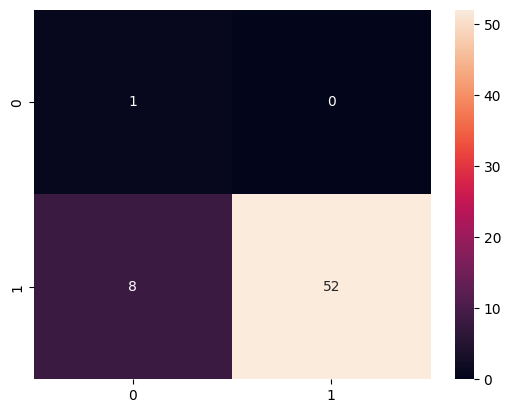

In [16]:
pred = rfr.predict(X_test)
# print(len(pred))
r2_score(pred , y_test)                  # Check the r2_score

cutoff = 0.7                             # decide on a cutoff limit
y_pred_classes = np.zeros_like(pred)     # initialise a matrix full with zeros
y_pred_classes[pred > cutoff] = 1    

#Get the confusion matrix
labels = df1.loc[:60,"Selling_Price"].to_numpy()
# print(len(labels))
y_test_classes = np.zeros_like(labels)
y_test_classes[labels > cutoff] = 1

cf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

acc_s = accuracy_score(y_test_classes, y_pred_classes)       # Aaccuracy score      
print(acc_s)
# Display F1 score
f1_score(y_test_classes,y_pred_classes)

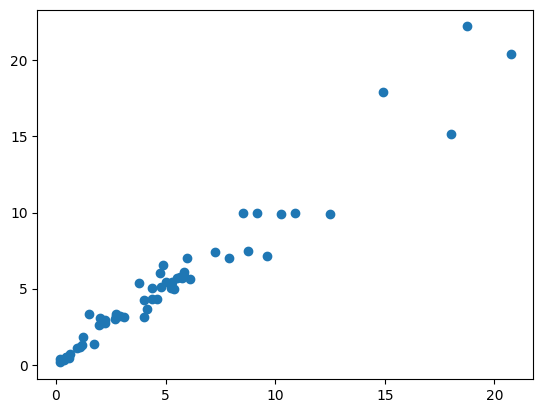

In [17]:
# Visualize the actual and predicted data
plt.scatter(y_test,pred)

# Output

In [26]:
pd.DataFrame(np.c_[y_test , pred] , columns =['Actual' , 'Predicted'])

,Actual,Predicted
0,12.50,9.884363
1,0.50,0.487996
2,0.65,0.690988
3,0.35,0.393559
4,14.90,17.886129
...,...,...
56,9.15,9.950456
57,4.75,6.030069
58,10.25,9.920330
59,0.38,0.302168


In [ ]:
pickled_model = pickle.load(open('car_price_prediction_model2.pkl', 'rb'))
pickled_model.predict(X_test)

In [22]:
file = open('car_price_prediction_model2.pkl','wb')
pickle.dump(rfr,file)

In [29]:
!pip freeze > requirements.txt